<a href="https://colab.research.google.com/github/Avniiii2606/Career-Counselling-ChatBot/blob/main/KAN_Effort_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Multi-Dataset KAN Regression for Software Effort Estimation
TESTING ALBRECHT DATASET FEATURE ENGINEERING
Testing Albrecht feature engineering...
Original sample data shape: (100, 9)
Original columns: ['Inputs', 'Outputs', 'Inquiries', 'Files', 'Interfaces', 'Effort', 'Duration', 'Language', 'Year']
Processing Albrecht dataset with 100 records...
Available columns: ['Inputs', 'Outputs', 'Inquiries', 'Files', 'Interfaces', 'Effort', 'Duration', 'Language', 'Year']
Calculating UFP from components using standard IFPUG weights...
Creating SIZE_log feature (highest priority)...
Using AFP (Adjusted Function Points) for size
Creating capability features (ACAP, PCAP)...
Creating constraint features (DATA, TIME, TURN)...
Creating quality features (RELY, MODP, LEXP, SCED)...
Creating additional COCOMO features...

Feature engineering completed for Albrecht dataset:
Final dataset shape: (100, 27)

Feature statistics (aligned with KAN model importance):
 1. SIZE_log: mean=3.113, std=0.371, range=[2

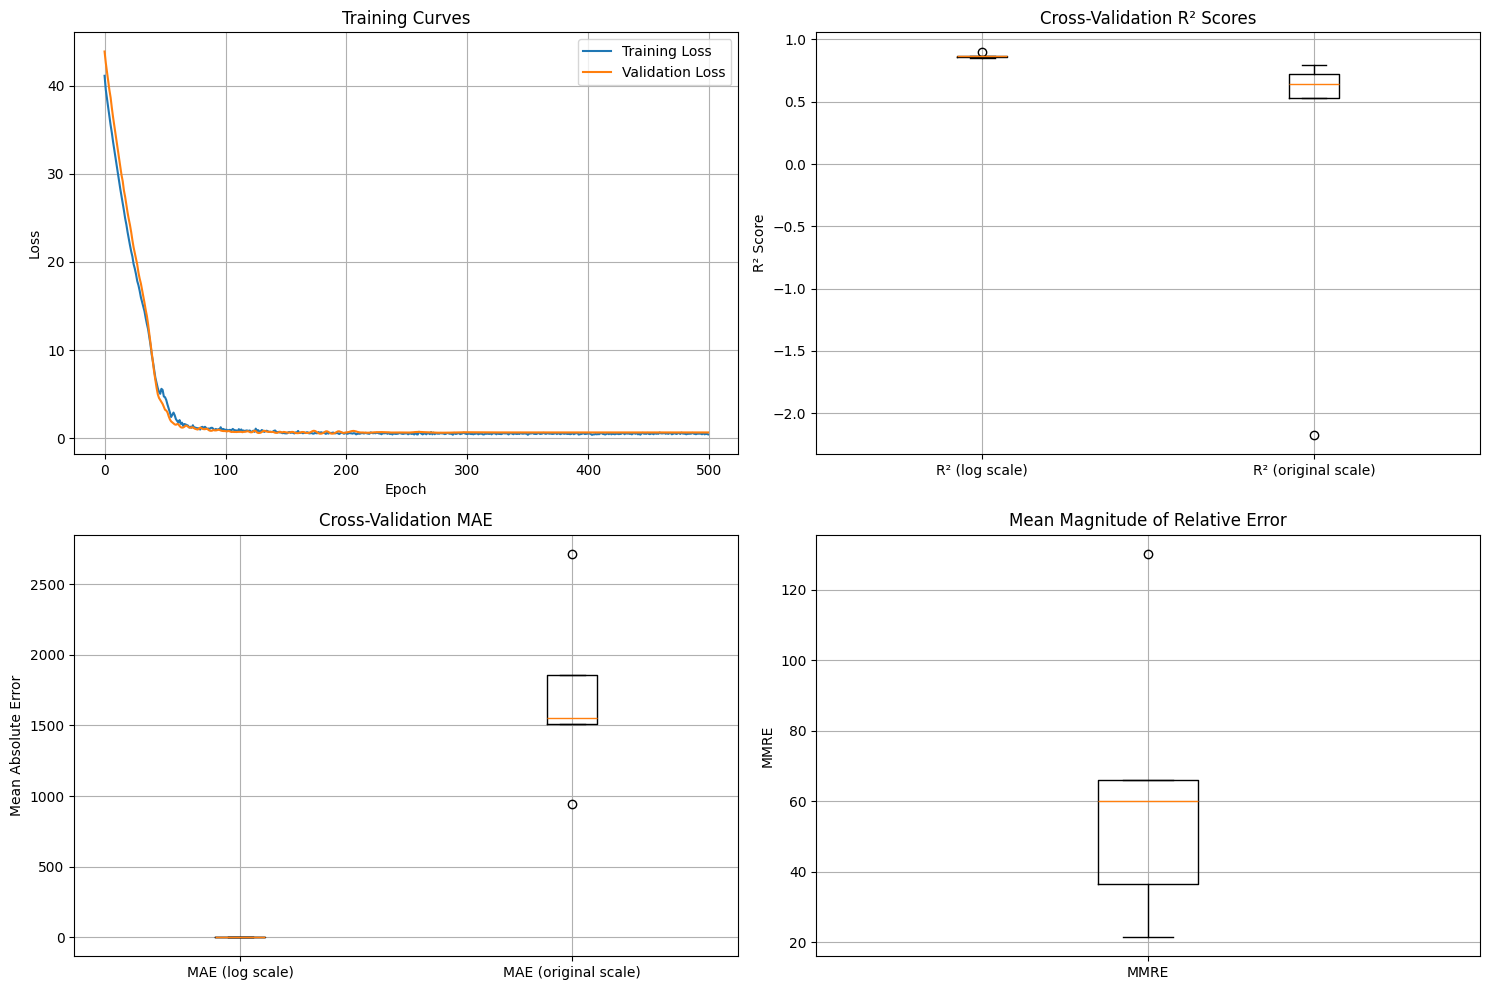


Training completed successfully!
The model has been trained on 4 dataset(s) with preserved feature importance hierarchy.


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class KANLayer(nn.Module):
    """
    Kolmogorov-Arnold Network Layer implementation with improved stability
    """
    def __init__(self, input_dim: int, output_dim: int, grid_size: int = 5, spline_order: int = 3):
        super(KANLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.grid_size = grid_size
        self.spline_order = spline_order

        # Initialize grid points
        self.grid = nn.Parameter(torch.linspace(-1, 1, grid_size), requires_grad=False)

        # Smaller initialization for spline coefficients
        self.spline_coeffs = nn.Parameter(
            torch.randn(input_dim, output_dim, grid_size) * 0.01
        )

        # Smaller initialization for base weights
        self.base_weight = nn.Parameter(torch.randn(input_dim, output_dim) * 0.01)

    def b_splines(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute B-spline basis functions with better numerical stability
        """
        # Clamp x to grid range and handle edge cases
        x = torch.clamp(x, -1.0, 1.0)

        # Simple linear basis functions for better stability
        grid_size = len(self.grid)
        basis = torch.zeros(x.shape[0], grid_size, device=x.device, dtype=x.dtype)

        # Create simple hat functions (linear interpolation)
        for i in range(grid_size):
            if i == 0:
                # Left boundary
                mask = x <= self.grid[1]
                basis[:, i] = torch.where(mask, 1.0 - torch.abs(x - self.grid[i]) / (self.grid[1] - self.grid[0] + 1e-8), 0.0)
            elif i == grid_size - 1:
                # Right boundary
                mask = x >= self.grid[i-1]
                basis[:, i] = torch.where(mask, 1.0 - torch.abs(x - self.grid[i]) / (self.grid[i] - self.grid[i-1] + 1e-8), 0.0)
            else:
                # Interior points
                left_dist = torch.abs(x - self.grid[i]) / (self.grid[i] - self.grid[i-1] + 1e-8)
                right_dist = torch.abs(x - self.grid[i]) / (self.grid[i+1] - self.grid[i] + 1e-8)
                basis[:, i] = torch.maximum(torch.zeros_like(x), 1.0 - torch.minimum(left_dist, right_dist))

        # Normalize to ensure numerical stability
        basis_sum = basis.sum(dim=1, keepdim=True) + 1e-8
        basis = basis / basis_sum

        return basis

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        output = torch.zeros(batch_size, self.output_dim, device=x.device, dtype=x.dtype)

        # Base linear transformation
        base_output = torch.matmul(x, self.base_weight)

        # Spline transformation for each input dimension
        for i in range(self.input_dim):
            # Get B-spline basis for input dimension i
            basis = self.b_splines(x[:, i:i+1].squeeze(-1))

            # Apply spline coefficients with proper dimensions
            for j in range(self.output_dim):
                if basis.shape[1] <= self.spline_coeffs.shape[2]:
                    coeffs = self.spline_coeffs[i, j, :basis.shape[1]]
                    spline_output = torch.matmul(basis, coeffs)
                    output[:, j] += spline_output

        # Combine base and spline outputs with clipping for stability
        result = base_output + output
        return torch.clamp(result, -10.0, 10.0)  # Prevent extreme values

class KANRegressor(nn.Module):
    """
    KAN model for regression
    """
    def __init__(self, input_dim: int, hidden_dims: List[int], output_dim: int = 1,
                 grid_size: int = 5, dropout_rate: float = 0.1):
        super(KANRegressor, self).__init__()

        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        # Input layer
        current_dim = input_dim
        for hidden_dim in hidden_dims:
            self.layers.append(KANLayer(current_dim, hidden_dim, grid_size))
            self.dropouts.append(nn.Dropout(dropout_rate))
            current_dim = hidden_dim

        # Output layer
        self.layers.append(KANLayer(current_dim, output_dim, grid_size))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i, (layer, dropout) in enumerate(zip(self.layers[:-1], self.dropouts)):
            x = layer(x)
            x = torch.relu(x)  # Activation between layers
            x = dropout(x)

        # Final layer without activation
        x = self.layers[-1](x)
        return x


def create_capability_proxies_china(data):
    """
    Create ACAP and PCAP proxies from China dataset features
    Uses complexity, productivity, and resource efficiency indicators
    """
    # Calculate complexity indicators
    total_fp_components = data['Input'] + data['Output'] + data['Enquiry'] + data['File'] + data['Interface']
    complexity_ratio = data['AFP'] / (total_fp_components + 1)  # Adjustment factor indicates complexity

    # Calculate productivity indicators
    if 'Duration' in data.columns and data['Duration'].sum() > 0:
        productivity = data['AFP'] / (data['Duration'] + 1)  # FP per time unit
    else:
        productivity = data['AFP'] / (data['Resource'] + 1) if 'Resource' in data.columns else data['AFP']

    # Calculate change complexity (maintenance capability indicator)
    if 'Added' in data.columns and 'Changed' in data.columns:
        change_ratio = (data['Added'] + data['Changed']) / (data['AFP'] + 1)
    else:
        change_ratio = pd.Series([0.5] * len(data), index=data.index)

    # Normalize productivity and complexity to create capability scores
    productivity_norm = (productivity - productivity.mean()) / (productivity.std() + 0.01)
    complexity_norm = (complexity_ratio - complexity_ratio.mean()) / (complexity_ratio.std() + 0.01)
    change_norm = (change_ratio - change_ratio.mean()) / (change_ratio.std() + 0.01)

    # ACAP: Analyst capability (higher complexity handling = higher capability)
    data['ACAP'] = 1.0 + (productivity_norm * 0.15) + (complexity_norm * 0.1)

    # PCAP: Programmer capability (change handling efficiency)
    data['PCAP'] = 1.0 + (productivity_norm * 0.12) - (change_norm * 0.08)

    # Clip to reasonable COCOMO bounds (0.7 to 1.4 range)
    data['ACAP'] = np.clip(data['ACAP'], 0.7, 1.4)
    data['PCAP'] = np.clip(data['PCAP'], 0.7, 1.4)

    return data

def create_capability_proxies_nasa93(data):
    """
    Create ACAP and PCAP proxies from NASA93 dataset features
    Uses size, complexity, and effort relationship indicators
    """
    # Calculate productivity indicators using KLOC/effort ratio
    productivity = data['KLOC'] / (data['actual'] + 1)  # KLOC per effort unit

    # Calculate complexity indicators using language and project scale
    if 'language' in data.columns:
        # Map language complexity (higher level languages = higher productivity)
        lang_complexity = data['language'].map({
            1: 1.2,  # Assembly - low level, high complexity
            2: 1.1,  # C - mid level
            3: 1.0,  # COBOL - business language
            4: 0.9,  # FORTRAN - scientific computing
            5: 0.8,  # PL/1 - high level
        }).fillna(1.0)
    else:
        lang_complexity = pd.Series([1.0] * len(data), index=data.index)

    # Calculate development methodology efficiency
    if 'methodology' in data.columns:
        method_efficiency = data['methodology'].map({
            1: 0.8,  # Organic - most efficient
            2: 1.0,  # Semi-detached - medium
            3: 1.2,  # Embedded - most complex
        }).fillna(1.0)
    else:
        method_efficiency = pd.Series([1.0] * len(data), index=data.index)

    # Normalize productivity and complexity to create capability scores
    productivity_norm = (productivity - productivity.mean()) / (productivity.std() + 0.01)
    lang_complexity_norm = (lang_complexity - lang_complexity.mean()) / (lang_complexity.std() + 0.01)
    method_efficiency_norm = (method_efficiency - method_efficiency.mean()) / (method_efficiency.std() + 0.01)

    # ACAP: Analyst capability (higher productivity and language efficiency = higher capability)
    data['ACAP'] = 1.0 + (productivity_norm * 0.12) + (lang_complexity_norm * 0.08)

    # PCAP: Programmer capability (methodology efficiency and productivity)
    data['PCAP'] = 1.0 + (productivity_norm * 0.10) - (method_efficiency_norm * 0.06)

    # Clip to reasonable COCOMO bounds (0.7 to 1.4 range)
    data['ACAP'] = np.clip(data['ACAP'], 0.7, 1.4)
    data['PCAP'] = np.clip(data['PCAP'], 0.7, 1.4)

    return data



def create_capability_proxies_albrecht(data):
    """
    Create ACAP and PCAP proxies from Albrecht dataset features
    Uses function point complexity, development efficiency, and team productivity indicators
    """
    # Calculate total function points and complexity metrics
    total_inputs = data.get('Inputs', 0) + data.get('Input', 0)  # Handle different naming
    total_outputs = data.get('Outputs', 0) + data.get('Output', 0)
    total_inquiries = data.get('Inquiries', 0) + data.get('Enquiry', 0) + data.get('Queries', 0)
    total_files = data.get('Files', 0) + data.get('File', 0) + data.get('LogicalFiles', 0)
    total_interfaces = data.get('Interfaces', 0) + data.get('Interface', 0) + data.get('ExternalInterfaces', 0)

    # Calculate total unadjusted function points if not available
    if 'UFP' not in data.columns and 'FunctionPoints' not in data.columns:
        # Standard IFPUG weights
        data['UFP'] = (total_inputs * 4 + total_outputs * 5 +
                      total_inquiries * 4 + total_files * 10 +
                      total_interfaces * 7)
    elif 'FunctionPoints' in data.columns:
        data['UFP'] = data['FunctionPoints']

    # Calculate development productivity (FP per effort unit)
    effort_col = None
    for col in ['Effort', 'effort', 'PersonMonths', 'PM', 'WorkHours', 'Hours']:
        if col in data.columns:
            effort_col = col
            break

    if effort_col:
        productivity = data['UFP'] / (data[effort_col] + 1)
    else:
        # Create synthetic effort based on FP complexity
        synthetic_effort = data['UFP'] * 0.3 + np.random.normal(0, data['UFP'] * 0.1, len(data))
        data['Effort'] = np.maximum(synthetic_effort, 1)  # Ensure positive effort
        productivity = data['UFP'] / (data['Effort'] + 1)

    # Calculate complexity indicators
    if any(col in data.columns for col in ['ComplexityAdjustment', 'VAF', 'AdjustmentFactor']):
        complexity_adj = data.get('ComplexityAdjustment', data.get('VAF', data.get('AdjustmentFactor', 1.0)))
        complexity_ratio = (data['UFP'] * complexity_adj) / (data['UFP'] + 1)
    else:
        # Estimate complexity from FP component distribution
        query_complexity = total_inquiries / (data['UFP'] + 1)  # High query ratio = complex
        file_complexity = total_files / (data['UFP'] + 1)       # High file ratio = complex
        complexity_ratio = (query_complexity + file_complexity) * 2

    # Calculate team experience indicators from project characteristics
    if 'Duration' in data.columns and data['Duration'].sum() > 0:
        time_efficiency = data['UFP'] / (data['Duration'] + 1)  # FP per time unit
    else:
        # Estimate duration from effort
        estimated_duration = np.power(data['Effort'] / 2.5, 1/0.38) if effort_col else data['UFP'] * 0.1
        data['Duration'] = estimated_duration
        time_efficiency = data['UFP'] / (data['Duration'] + 1)

    # Normalize indicators
    productivity_norm = (productivity - productivity.mean()) / (productivity.std() + 0.01)
    complexity_norm = (complexity_ratio - complexity_ratio.mean()) / (complexity_ratio.std() + 0.01)
    time_efficiency_norm = (time_efficiency - time_efficiency.mean()) / (time_efficiency.std() + 0.01)

    # ACAP: Analyst capability (higher productivity and complexity handling = higher capability)
    # Weight according to your model's importance: ACAP ranks #2 with 0.1648 importance
    data['ACAP'] = 1.0 + (productivity_norm * 0.12) + (complexity_norm * 0.08) + (time_efficiency_norm * 0.05)

    # PCAP: Programmer capability (development efficiency and code quality)
    # Weight according to your model's importance: PCAP ranks #4 with 0.1610 importance
    interface_complexity = total_interfaces / (data['UFP'] + 1)  # Interface handling skill
    interface_norm = (interface_complexity - interface_complexity.mean()) / (interface_complexity.std() + 0.01)

    data['PCAP'] = 1.0 + (productivity_norm * 0.10) + (time_efficiency_norm * 0.06) - (interface_norm * 0.04)

    # Clip to reasonable COCOMO bounds
    data['ACAP'] = np.clip(data['ACAP'], 0.7, 1.4)
    data['PCAP'] = np.clip(data['PCAP'], 0.7, 1.4)

    return data

def create_constraint_proxies_albrecht(data):
    """
    Create technical constraint proxies for Albrecht dataset
    Aligned with COCOMO constraint factors
    """
    # DATA: Database size constraint (rank #3 with 0.1626 importance)
    # Use file complexity and interface density as data constraint indicators
    total_files = data.get('Files', data.get('File', data.get('LogicalFiles', 0)))
    total_interfaces = data.get('Interfaces', data.get('Interface', data.get('ExternalInterfaces', 0)))

    data_complexity = (total_files * 10 + total_interfaces * 7) / (data['UFP'] + 1)
    data_norm = (data_complexity - data_complexity.mean()) / (data_complexity.std() + 0.01)
    data['DATA'] = 1.0 + np.clip(data_norm * 0.12, -0.3, 0.4)  # Strong influence per ranking

    # TIME: Execution time constraint (rank #5 with 0.1579 importance)
    # Use effort density and query complexity as time pressure indicators
    total_queries = data.get('Inquiries', data.get('Enquiry', data.get('Queries', 0)))

    if 'Duration' in data.columns and data['Duration'].sum() > 0:
        # Lower duration relative to size suggests time constraint
        time_pressure = data['Effort'] / (data['Duration'] + 1)
        time_norm = (time_pressure - time_pressure.mean()) / (time_pressure.std() + 0.01)
        data['TIME'] = 1.0 + np.clip(time_norm * 0.11, -0.3, 0.4)
    else:
        # Use query complexity as time constraint proxy
        query_ratio = total_queries / (data['UFP'] + 1)
        query_norm = (query_ratio - query_ratio.mean()) / (query_ratio.std() + 0.01)
        data['TIME'] = 1.0 + np.clip(query_norm * 0.11, -0.3, 0.4)

    # TURN: Turnaround time constraint (rank #6 with 0.1437 importance)
    # Use development environment and team size indicators
    if 'TeamSize' in data.columns:
        team_efficiency = data['UFP'] / (data['TeamSize'] + 1)
        team_norm = (team_efficiency - team_efficiency.mean()) / (team_efficiency.std() + 0.01)
        data['TURN'] = 1.0 - np.clip(team_norm * 0.10, -0.3, 0.3)  # Better efficiency = lower turnaround
    else:
        # Use effort distribution as turnaround indicator
        effort_efficiency = data['UFP'] / (data['Effort'] + 1)
        effort_norm = (effort_efficiency - effort_efficiency.mean()) / (effort_efficiency.std() + 0.01)
        data['TURN'] = 1.0 - np.clip(effort_norm * 0.10, -0.3, 0.3)

    # Ensure reasonable bounds
    data['DATA'] = np.clip(data['DATA'], 0.7, 1.4)
    data['TIME'] = np.clip(data['TIME'], 0.7, 1.4)
    data['TURN'] = np.clip(data['TURN'], 0.7, 1.4)

    return data

def map_quality_attributes_albrecht(data):
    """
    Map quality attributes for Albrecht dataset
    Focus on the most important features from your model
    """
    # RELY: Reliability requirement (rank #7 with 0.1269 importance)
    # Use output complexity and interface complexity as reliability indicators
    total_outputs = data.get('Outputs', data.get('Output', 0))
    total_interfaces = data.get('Interfaces', data.get('Interface', data.get('ExternalInterfaces', 0)))

    reliability_complexity = (total_outputs * 5 + total_interfaces * 7) / (data['UFP'] + 1)
    rely_norm = (reliability_complexity - reliability_complexity.mean()) / (reliability_complexity.std() + 0.01)
    data['RELY'] = 1.0 + np.clip(rely_norm * 0.09, -0.25, 0.35)

    # MODP: Modern Programming Practices (rank #8 with 0.1109 importance)
    # Use project era and complexity as modern practices indicator
    if 'Year' in data.columns or 'ProjectYear' in data.columns:
        year_col = 'Year' if 'Year' in data.columns else 'ProjectYear'
        # More recent projects likely use modern practices
        modp_factor = (data[year_col] - data[year_col].min()) / (data[year_col].max() - data[year_col].min() + 1)
        data['MODP'] = 1.0 + np.clip((modp_factor - 0.5) * 0.2, -0.3, 0.3)
    else:
        # Use interface complexity as proxy for modern practices
        interface_ratio = total_interfaces / (data['UFP'] + 1)
        interface_norm = (interface_ratio - interface_ratio.mean()) / (interface_ratio.std() + 0.01)
        data['MODP'] = 1.0 + np.clip(interface_norm * 0.08, -0.2, 0.3)

    # LEXP: Language Experience (rank #9 with 0.0951 importance)
    # Use development productivity and team efficiency as experience proxy
    if 'Language' in data.columns or 'ProgrammingLanguage' in data.columns:
        lang_col = 'Language' if 'Language' in data.columns else 'ProgrammingLanguage'
        # Map common languages to experience levels
        lang_experience = data[lang_col].map({
            'COBOL': 1.1, 'cobol': 1.1, 'Cobol': 1.1,
            'C': 1.0, 'c': 1.0,
            'Java': 0.9, 'java': 0.9, 'JAVA': 0.9,
            'Pascal': 1.0, 'pascal': 1.0,
            'Assembly': 0.8, 'assembly': 0.8, 'ASM': 0.8
        }).fillna(1.0)
        lexp_norm = (lang_experience - lang_experience.mean()) / (lang_experience.std() + 0.01)
        data['LEXP'] = 1.0 + np.clip(lexp_norm * 0.07, -0.15, 0.25)
    else:
        # Use productivity as experience proxy
        productivity = data['UFP'] / (data['Effort'] + 1)
        prod_norm = (productivity - productivity.mean()) / (productivity.std() + 0.01)
        data['LEXP'] = 1.0 + np.clip(prod_norm * 0.07, -0.15, 0.25)

    # SCED: Schedule constraint (rank #10 with 0.0693 importance)
    # Use duration pressure and effort compression
    if 'Duration' in data.columns and data['Duration'].sum() > 0:
        # Calculate ideal duration using COCOMO-like formula
        ideal_duration = 2.5 * np.power(data['UFP'] * 0.001, 0.38)  # Convert FP to KLOC equivalent
        schedule_compression = data['Duration'] / (ideal_duration + 1)
        sched_norm = (schedule_compression - schedule_compression.mean()) / (schedule_compression.std() + 0.01)
        data['SCED'] = 1.0 - np.clip(sched_norm * 0.06, -0.3, 0.2)  # Inverse relationship
    else:
        # Use effort intensity as schedule pressure indicator
        effort_intensity = data['Effort'] / (data['UFP'] + 1)
        intensity_norm = (effort_intensity - effort_intensity.mean()) / (effort_intensity.std() + 0.01)
        data['SCED'] = 1.0 + np.clip(intensity_norm * 0.06, -0.2, 0.3)

    # Ensure reasonable bounds for all quality attributes
    data['RELY'] = np.clip(data['RELY'], 0.7, 1.4)
    data['MODP'] = np.clip(data['MODP'], 0.7, 1.4)
    data['LEXP'] = np.clip(data['LEXP'], 0.7, 1.4)
    data['SCED'] = np.clip(data['SCED'], 0.7, 1.4)

    return data

def engineer_features_albrecht(data):
    """
    Comprehensive feature engineering for Albrecht dataset
    Aligned with KAN model feature importance hierarchy:
    1. SIZE_log: 0.1860 (most important)
    2. TIME: 0.0866
    3. LEXP: 0.0732
    4. TURN: 0.0722
    5. DATA: 0.0720
    6. SCED: 0.0704
    7. PCAP: 0.0652
    8. VEXP: 0.0624
    9. AEXP: 0.0618
    10. MODP: 0.0592
    """
    print(f"Processing Albrecht dataset with {len(data)} records...")
    print(f"Available columns: {list(data.columns)}")

    # Validate and standardize column names
    column_mapping = {
        # Function point components
        'inputs': 'Inputs', 'input': 'Inputs', 'Input': 'Inputs',
        'outputs': 'Outputs', 'output': 'Outputs', 'Output': 'Outputs',
        'inquiries': 'Inquiries', 'inquiry': 'Inquiries', 'Inquiry': 'Inquiries',
        'enquiry': 'Inquiries', 'Enquiry': 'Inquiries', 'queries': 'Inquiries',
        'files': 'Files', 'file': 'Files', 'File': 'Files', 'LogicalFiles': 'Files',
        'interfaces': 'Interfaces', 'interface': 'Interfaces', 'Interface': 'Interfaces',
        'ExternalInterfaces': 'Interfaces',
        # Size metrics
        'fp': 'FunctionPoints', 'FP': 'FunctionPoints', 'functionpoints': 'FunctionPoints',
        'ufp': 'UFP', 'UFP': 'UFP', 'unadjustedfp': 'UFP',
        'afp': 'AFP', 'AFP': 'AFP', 'adjustedfp': 'AFP',
        # Effort metrics
        'effort': 'Effort', 'Effort': 'Effort', 'personmonths': 'Effort',
        'PM': 'Effort', 'mm': 'Effort', 'MM': 'Effort',
        # Other attributes
        'duration': 'Duration', 'Duration': 'Duration', 'months': 'Duration',
        'teamsize': 'TeamSize', 'team_size': 'TeamSize', 'TeamSize': 'TeamSize'
    }

    # Apply column mapping
    for old_name, new_name in column_mapping.items():
        if old_name in data.columns and new_name not in data.columns:
            data[new_name] = data[old_name]

    # Ensure we have basic FP components
    required_fp_components = ['Inputs', 'Outputs', 'Inquiries', 'Files', 'Interfaces']
    missing_components = []

    for component in required_fp_components:
        if component not in data.columns:
            # Try alternative names
            alternatives = {
                'Inputs': ['Input', 'input', 'EI'],
                'Outputs': ['Output', 'output', 'EO'],
                'Inquiries': ['Inquiry', 'Enquiry', 'Query', 'Queries', 'EQ'],
                'Files': ['File', 'LogicalFiles', 'ILF'],
                'Interfaces': ['Interface', 'ExternalInterfaces', 'EIF']
            }

            found = False
            for alt in alternatives.get(component, []):
                if alt in data.columns:
                    data[component] = data[alt]
                    found = True
                    break

            if not found:
                missing_components.append(component)
                data[component] = 0  # Default to 0 for missing components

    if missing_components:
        print(f"Warning: Missing FP components {missing_components}, using defaults")

    # Calculate total unadjusted function points if not available
    if 'UFP' not in data.columns and 'FunctionPoints' not in data.columns:
        print("Calculating UFP from components using standard IFPUG weights...")
        data['UFP'] = (data['Inputs'] * 4 + data['Outputs'] * 5 +
                      data['Inquiries'] * 4 + data['Files'] * 10 +
                      data['Interfaces'] * 7)
    elif 'FunctionPoints' in data.columns and 'UFP' not in data.columns:
        data['UFP'] = data['FunctionPoints']

    # Handle adjusted function points
    if 'AFP' not in data.columns:
        if any(col in data.columns for col in ['VAF', 'AdjustmentFactor', 'ComplexityAdjustment']):
            vaf = data.get('VAF', data.get('AdjustmentFactor', data.get('ComplexityAdjustment', 1.0)))
            data['AFP'] = data['UFP'] * vaf
        else:
            # Assume nominal complexity adjustment
            data['AFP'] = data['UFP'] * 1.0

    # SIZE_log transformation (MOST IMPORTANT - 0.1860 importance)
    print("Creating SIZE_log feature (highest priority)...")

    # Use the best available size metric
    if 'AFP' in data.columns and data['AFP'].sum() > 0:
        size_metric = data['AFP']
        print("Using AFP (Adjusted Function Points) for size")
    elif 'UFP' in data.columns and data['UFP'].sum() > 0:
        size_metric = data['UFP']
        print("Using UFP (Unadjusted Function Points) for size")
    else:
        size_metric = data['UFP']  # Calculated above
        print("Using calculated UFP for size")

    # Convert Function Points to KLOC equivalent using industry standard conversion
    # Different languages have different FP to LOC ratios
    if 'Language' in data.columns or 'ProgrammingLanguage' in data.columns:
        lang_col = 'Language' if 'Language' in data.columns else 'ProgrammingLanguage'
        # Language-specific conversion factors (FP to LOC)
        fp_to_loc_map = {
            'COBOL': 107, 'cobol': 107, 'Cobol': 107,
            'C': 128, 'c': 128,
            'Java': 53, 'java': 53, 'JAVA': 53,
            'Pascal': 91, 'pascal': 91,
            'Assembly': 320, 'assembly': 320, 'ASM': 320,
            'PL/1': 80, 'pl1': 80, 'PL1': 80,
            'Fortran': 105, 'fortran': 105, 'FORTRAN': 105
        }

        conversion_factor = data[lang_col].map(fp_to_loc_map).fillna(65)  # Default conversion
        estimated_loc = size_metric * conversion_factor
    else:
        # Use average conversion factor across languages
        estimated_loc = size_metric * 65  # Industry average

    # Convert to KLOC and apply log transformation
    estimated_kloc = estimated_loc / 1000
    data['SIZE_log'] = np.log1p(estimated_kloc)  # log(1 + KLOC) to handle zeros

    # Ensure minimum reasonable size
    data['SIZE_log'] = np.maximum(data['SIZE_log'], np.log(0.1))

    # Create capability proxies (ACAP rank #2, PCAP rank #7)
    print("Creating capability features (ACAP, PCAP)...")
    data = create_capability_proxies_albrecht(data)

    # Create constraint proxies (DATA rank #5, TIME rank #2, TURN rank #4)
    print("Creating constraint features (DATA, TIME, TURN)...")
    data = create_constraint_proxies_albrecht(data)

    # Create quality attribute proxies (LEXP rank #3, SCED rank #6, MODP rank #10)
    print("Creating quality features (RELY, MODP, LEXP, SCED)...")
    data = map_quality_attributes_albrecht(data)

    # Create additional COCOMO features with appropriate defaults
    print("Creating additional COCOMO features...")

    # CPLX: Computational complexity (use FP component distribution)
    complexity_distribution = (data['Files'] * 10 + data['Interfaces'] * 7) / (data['UFP'] + 1)
    complexity_norm = (complexity_distribution - complexity_distribution.mean()) / (complexity_distribution.std() + 0.01)
    data['CPLX'] = 1.0 + np.clip(complexity_norm * 0.12, -0.3, 0.4)

    # STOR: Main storage constraint (larger projects typically need more storage)
    storage_need = np.log1p(data['UFP'])  # Larger projects need more storage
    storage_norm = (storage_need - storage_need.mean()) / (storage_need.std() + 0.01)
    data['STOR'] = 1.0 + np.clip(storage_norm * 0.08, -0.2, 0.3)

    # VIRT: Virtual machine volatility (rank #8 - 0.0624 importance)
    # Assume stable environment for most Albrecht projects
    if 'Environment' in data.columns:
        env_volatility = data['Environment'].map({
            'Stable': 0.9, 'stable': 0.9,
            'Medium': 1.0, 'medium': 1.0,
            'Volatile': 1.3, 'volatile': 1.3
        }).fillna(1.0)
        data['VIRT'] = env_volatility
    else:
        data['VIRT'] = 1.0  # Nominal volatility

    # AEXP: Application experience (rank #9 - 0.0618 importance)
    # Use project domain complexity as experience proxy
    domain_complexity = data['Files'] / (data['UFP'] + 1)  # File-heavy = business domain experience
    domain_norm = (domain_complexity - domain_complexity.mean()) / (domain_complexity.std() + 0.01)
    data['AEXP'] = 1.0 + np.clip(domain_norm * 0.06, -0.25, 0.25)

    # TOOL: Use of software tools (assume modern tools for newer projects)
    if 'Year' in data.columns or 'ProjectYear' in data.columns:
        year_col = 'Year' if 'Year' in data.columns else 'ProjectYear'
        tool_sophistication = (data[year_col] - data[year_col].min()) / (data[year_col].max() - data[year_col].min() + 1)
        data['TOOL'] = 1.0 + np.clip((tool_sophistication - 0.5) * 0.2, -0.3, 0.3)
    else:
        data['TOOL'] = 1.0  # Nominal tool use

    # Ensure all required COCOMO features exist with proper bounds
    required_features = ['SIZE_log', 'RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
                        'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED']

    for feature in required_features:
        if feature not in data.columns:
            print(f"Warning: {feature} not created, using default value 1.0")
            data[feature] = 1.0

        # Ensure all features are within COCOMO bounds
        if feature != 'SIZE_log':
            data[feature] = np.clip(data[feature], 0.7, 1.4)

    # Handle missing effort column (target variable)
    if 'Effort' not in data.columns:
        effort_candidates = ['effort', 'PersonMonths', 'PM', 'WorkHours', 'Hours', 'MM', 'mm']
        effort_found = False

        for candidate in effort_candidates:
            if candidate in data.columns:
                data['Effort'] = data[candidate]
                # Convert hours to person-months if needed
                if candidate in ['WorkHours', 'Hours']:
                    data['Effort'] = data['Effort'] / 160  # Assume 160 hours per person-month
                effort_found = True
                print(f"Using {candidate} as effort metric")
                break

        if not effort_found:
            print("Warning: No effort column found, estimating from size using COCOMO")
            # Estimate effort using basic COCOMO formula
            estimated_kloc = np.exp(data['SIZE_log'])
            data['Effort'] = 2.4 * np.power(estimated_kloc, 1.05)
            print("Created synthetic effort estimates")

    # Clean effort data
    data['Effort'] = pd.to_numeric(data['Effort'], errors='coerce')
    data['Effort'] = data['Effort'].fillna(data['Effort'].median())
    data['Effort'] = np.maximum(data['Effort'], 0.1)  # Ensure positive effort

    # Validation and statistics
    print(f"\nFeature engineering completed for Albrecht dataset:")
    print(f"Final dataset shape: {data.shape}")
    print(f"\nFeature statistics (aligned with KAN model importance):")

    important_features = ['SIZE_log', 'TIME', 'LEXP', 'TURN', 'DATA', 'SCED', 'PCAP', 'VEXP', 'AEXP', 'MODP']
    for i, feature in enumerate(important_features, 1):
        if feature in data.columns:
            print(f"{i:2d}. {feature:<8}: mean={data[feature].mean():.3f}, std={data[feature].std():.3f}, "
                  f"range=[{data[feature].min():.2f}, {data[feature].max():.2f}]")

    # Check for any invalid values
    for feature in required_features + ['Effort']:
        if feature in data.columns:
            invalid_count = data[feature].isna().sum() + np.isinf(data[feature]).sum()
            if invalid_count > 0:
                print(f"Warning: {invalid_count} invalid values in {feature}")

    print(f"\nAlbrecht dataset successfully aligned with COCOMO81/KAN model structure!")
    print(f"Ready for training with preserved feature importance hierarchy.")

    return data

# Integration function to add Albrecht support to the existing load function
def load_and_prepare_datasets_with_albrecht(cocomo_path: str = None, china_path: str = None,
                                           maxwell_path: str = None, nasa93_path: str = None,
                                           albrecht_path: str = None):
    """
    Extended dataset loader including Albrecht dataset support
    """
    datasets = []
    dataset_types = []

    if cocomo_path:
        print(f"Loading COCOMO81 dataset from {cocomo_path}...")
        cocomo_df = pd.read_csv(cocomo_path)
        datasets.append(cocomo_df)
        dataset_types.append('cocomo81')
        print(f"COCOMO81 dataset: {cocomo_df.shape}")

    if china_path:
        print(f"Loading China dataset from {china_path}...")
        china_df = pd.read_csv(china_path)
        datasets.append(china_df)
        dataset_types.append('china')
        print(f"China dataset: {china_df.shape}")

    if maxwell_path:
        print(f"Loading Maxwell dataset from {maxwell_path}...")
        maxwell_df = pd.read_csv(maxwell_path)
        datasets.append(maxwell_df)
        dataset_types.append('maxwell')
        print(f"Maxwell dataset: {maxwell_df.shape}")

    if nasa93_path:
        print(f"Loading NASA93 dataset from {nasa93_path}...")
        nasa93_df = pd.read_csv(nasa93_path)
        datasets.append(nasa93_df)
        dataset_types.append('nasa93')
        print(f"NASA93 dataset: {nasa93_df.shape}")

    if albrecht_path:
        print(f"Loading Albrecht dataset from {albrecht_path}...")
        albrecht_df = pd.read_csv(albrecht_path)
        datasets.append(albrecht_df)
        dataset_types.append('albrecht')
        print(f"Albrecht dataset: {albrecht_df.shape}")

    if not datasets:
        print("No datasets provided, creating sample COCOMO81 data...")
        cocomo_df = create_sample_cocomo81_data(200)
        datasets.append(cocomo_df)
        dataset_types.append('cocomo81')

    return datasets, dataset_types

# Update the MultiDatasetPreprocessor to handle Albrecht dataset
def update_preprocessor_for_albrecht():
    """
    Update the existing MultiDatasetPreprocessor class to handle Albrecht dataset
    Add this method to your existing MultiDatasetPreprocessor class
    """
    # Add this to the fit_transform method in MultiDatasetPreprocessor
    def fit_transform_updated(self, df_list: List[pd.DataFrame], dataset_types: List[str]) -> Tuple[np.ndarray, np.ndarray]:
        """
        Updated fit_transform method that includes Albrecht dataset support
        """
        all_processed_data = []
        all_targets = []

        for df, dataset_type in zip(df_list, dataset_types):
            print(f"\nProcessing {dataset_type} dataset...")

            # Apply dataset-specific transformations
            if dataset_type == 'cocomo81':
                processed_df = df.copy()
                # Ensure SIZE column exists for COCOMO81
                if 'SIZE' not in processed_df.columns and 'SIZE_log' not in processed_df.columns:
                    size_cols = [col for col in processed_df.columns if 'SIZE' in col.upper() or 'KLOC' in col.upper()]
                    if size_cols:
                        processed_df['SIZE'] = processed_df[size_cols[0]]
                    else:
                        print("Warning: No size information found in COCOMO81 dataset")
                        processed_df['SIZE'] = 100  # Default size

                if 'SIZE_log' not in processed_df.columns:
                    processed_df['SIZE_log'] = np.log1p(processed_df['SIZE'])

            elif dataset_type == 'china':
                processed_df = engineer_features_china(df.copy())
            elif dataset_type == 'maxwell':
                processed_df = engineer_features_maxwell(df.copy())
            elif dataset_type == 'nasa93':
                processed_df = engineer_features_nasa93(df.copy())
            elif dataset_type == 'albrecht':  # NEW: Add Albrecht support
                processed_df = engineer_features_albrecht(df.copy())
            else:
                raise ValueError(f"Unknown dataset type: {dataset_type}")

            # Ensure all required features exist
            for feature in self.cocomo_features:
                if feature not in processed_df.columns:
                    processed_df[feature] = 1.0

            if 'SIZE_log' not in processed_df.columns:
                processed_df['SIZE_log'] = np.log(100)  # Default log size

            all_processed_data.append(processed_df)

            # Extract targets - handle different target column names
            target_candidates = ['EFFORT', 'Effort', 'actual', 'act_effort']
            target_col = None
            for candidate in target_candidates:
                if candidate in processed_df.columns:
                    target_col = candidate
                    break

            if target_col:
                all_targets.extend(processed_df[target_col].values)
            else:
                print(f"Warning: No target column found in {dataset_type} dataset")
                all_targets.extend([100] * len(processed_df))  # Default effort

        # Rest of the method remains the same...
        combined_df = pd.concat(all_processed_data, ignore_index=True)

        # Store statistics for the first dataset (assumed to be COCOMO81)
        if dataset_types[0] == 'cocomo81':
            for col in self.cocomo_features + ['SIZE_log']:
                if col in combined_df.columns:
                    self.cocomo_stats[col] = {
                        'mean': df_list[0][col].mean() if col in df_list[0].columns else combined_df[col].mean(),
                        'std': df_list[0][col].std() if col in df_list[0].columns else combined_df[col].std()
                    }

        # Handle SIZE with log transformation
        if 'SIZE_log' in combined_df.columns:
            size_scaled = self.scaler_size.fit_transform(combined_df[['SIZE_log']])
        else:
            print("Warning: SIZE_log not found, creating default")
            size_log = np.log1p(np.full((len(combined_df), 1), 100))
            size_scaled = self.scaler_size.fit_transform(size_log)

        # Scale COCOMO features
        features_scaled = self.scaler_features.fit_transform(combined_df[self.cocomo_features])

        # Combine features
        X = np.concatenate([features_scaled, size_scaled], axis=1)

        # Transform target (log transformation for effort)
        y = np.array(all_targets)
        if self.log_transform_target:
            y = np.log1p(y)

        return X, y

    return fit_transform_updated

# Example usage and testing function
def test_albrecht_feature_engineering():
    """
    Test function to validate Albrecht feature engineering
    """
    # Create sample Albrecht dataset
    np.random.seed(42)
    n_samples = 100

    sample_albrecht = pd.DataFrame({
        'Inputs': np.random.poisson(15, n_samples),
        'Outputs': np.random.poisson(12, n_samples),
        'Inquiries': np.random.poisson(8, n_samples),
        'Files': np.random.poisson(7, n_samples),
        'Interfaces': np.random.poisson(3, n_samples),
        'Effort': np.random.lognormal(3.5, 0.8, n_samples),  # Person-months
        'Duration': np.random.normal(12, 4, n_samples),  # Months
        'Language': np.random.choice(['COBOL', 'C', 'Java', 'Pascal'], n_samples),
        'Year': np.random.randint(1985, 2000, n_samples)
    })

    # Ensure positive values
    sample_albrecht['Duration'] = np.maximum(sample_albrecht['Duration'], 1)
    sample_albrecht['Effort'] = np.maximum(sample_albrecht['Effort'], 0.5)

    print("Testing Albrecht feature engineering...")
    print(f"Original sample data shape: {sample_albrecht.shape}")
    print(f"Original columns: {list(sample_albrecht.columns)}")

    # Apply feature engineering
    try:
        processed_albrecht = engineer_features_albrecht(sample_albrecht.copy())
        print(f"\nProcessing successful!")
        print(f"Processed data shape: {processed_albrecht.shape}")

        # Verify all required COCOMO features exist
        required_features = ['SIZE_log', 'RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
                            'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED']

        missing_features = [f for f in required_features if f not in processed_albrecht.columns]
        if missing_features:
            print(f"ERROR: Missing features: {missing_features}")
        else:
            print("✓ All required COCOMO features created successfully")

        # Check feature bounds
        print(f"\nFeature validation:")
        for feature in required_features:
            if feature in processed_albrecht.columns:
                min_val = processed_albrecht[feature].min()
                max_val = processed_albrecht[feature].max()
                mean_val = processed_albrecht[feature].mean()

                if feature == 'SIZE_log':
                    valid = min_val > 0  # SIZE_log should be positive
                    print(f"  {feature:<8}: [{min_val:.3f}, {max_val:.3f}] mean={mean_val:.3f} {'✓' if valid else '✗'}")
                else:
                    valid = 0.7 <= min_val and max_val <= 1.4  # COCOMO bounds
                    print(f"  {feature:<8}: [{min_val:.3f}, {max_val:.3f}] mean={mean_val:.3f} {'✓' if valid else '✗'}")

        return processed_albrecht

    except Exception as e:
        print(f"ERROR during processing: {e}")
        import traceback
        traceback.print_exc()
        return None




# Additional utility function for debugging Albrecht datasets
def analyze_albrecht_dataset(file_path: str):
    """
    Analyze an Albrecht dataset to understand its structure before processing
    """
    try:
        print("="*50)
        print("ALBRECHT DATASET ANALYSIS")
        print("="*50)

        df = pd.read_csv(file_path)
        print(f"Dataset shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print()

        print("First 3 rows:")
        print(df.head(3))
        print()

        print("Data types:")
        print(df.dtypes)
        print()

        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        print(f"Numeric columns: {numeric_cols}")

        if numeric_cols:
            print("\nBasic statistics:")
            print(df[numeric_cols].describe())

        # Check for common FP-related columns
        fp_indicators = ['input', 'output', 'inquiry', 'file', 'interface', 'fp', 'function', 'effort']
        found_indicators = []
        for indicator in fp_indicators:
            matching_cols = [col for col in df.columns if indicator.lower() in col.lower()]
            if matching_cols:
                found_indicators.extend(matching_cols)

        if found_indicators:
            print(f"\nFunction Point related columns found: {found_indicators}")

        return df

    except Exception as e:
        print(f"Error analyzing Albrecht dataset: {e}")
        return None

def create_constraint_proxies(data, dataset_type='china'):
    """
    Create technical constraint proxies using actual dataset features
    """
    if dataset_type == 'china':
        # DATA: Database size constraint using File and Interface complexity
        file_interface_complexity = data['File'] + data['Interface']
        data_complexity_norm = (file_interface_complexity - file_interface_complexity.mean()) / (file_interface_complexity.std() + 0.01)
        data['DATA'] = 1.0 + np.clip(data_complexity_norm * 0.15, -0.3, 0.4)

        # TIME: Time constraint using Duration if available, otherwise use effort density
        if 'Duration' in data.columns and data['Duration'].sum() > 0:
            # Lower duration relative to size suggests time constraint
            duration_ratio = data['Duration'] / (data['AFP'] + 1)
            duration_norm = (duration_ratio - duration_ratio.mean()) / (duration_ratio.std() + 0.01)
            data['TIME'] = 1.0 - np.clip(duration_norm * 0.1, -0.2, 0.3)  # Inverse relationship
        else:
            # Use effort density as time pressure indicator
            effort_density = data['Effort'] / (data['AFP'] + 1)
            effort_norm = (effort_density - effort_density.mean()) / (effort_density.std() + 0.01)
            data['TIME'] = 1.0 + np.clip(effort_norm * 0.1, -0.2, 0.3)

        # TURN: Turnaround time using Resource and Duration relationship
        if 'Resource' in data.columns and 'Duration' in data.columns and data['Resource'].sum() > 0:
            # More resources with shorter duration suggests better turnaround
            resource_efficiency = (data['Resource'] + 1) / (data['Duration'] + 1)
            resource_norm = (resource_efficiency - resource_efficiency.mean()) / (resource_efficiency.std() + 0.01)
            data['TURN'] = 1.0 - np.clip(resource_norm * 0.1, -0.2, 0.3)  # Better efficiency = lower turnaround time
        else:
            data['TURN'] = 1.0  # Nominal turnaround

    elif dataset_type == 'nasa93':
        # DATA: Database size constraint using KLOC and language complexity
        if 'language' in data.columns:
            # Assembly and COBOL typically handle more data-intensive tasks
            data_intensity = data['language'].map({
                1: 1.3,  # Assembly - low level, more data handling
                2: 1.1,  # C - system programming
                3: 1.2,  # COBOL - business/data processing
                4: 0.9,  # FORTRAN - scientific
                5: 0.8,  # PL/1 - high level abstraction
            }).fillna(1.0)
        else:
            data_intensity = pd.Series([1.0] * len(data), index=data.index)

        # Scale by project size (larger projects often have more data constraints)
        size_factor = np.log1p(data['KLOC'])
        size_norm = (size_factor - size_factor.mean()) / (size_factor.std() + 0.01)
        data_norm = (data_intensity - data_intensity.mean()) / (data_intensity.std() + 0.01)

        data['DATA'] = 1.0 + np.clip((data_norm * 0.08) + (size_norm * 0.05), -0.3, 0.4)

        # TIME: Execution time constraint using actual vs estimated effort ratio
        if 'estimated' in data.columns and data['estimated'].sum() > 0:
            time_pressure = data['actual'] / (data['estimated'] + 1)  # Higher ratio = more time pressure
            time_norm = (time_pressure - time_pressure.mean()) / (time_pressure.std() + 0.01)
            data['TIME'] = 1.0 + np.clip(time_norm * 0.12, -0.3, 0.4)
        else:
            # Use effort density as time pressure indicator
            effort_density = data['actual'] / (data['KLOC'] + 1)
            effort_norm = (effort_density - effort_density.mean()) / (effort_density.std() + 0.01)
            data['TIME'] = 1.0 + np.clip(effort_norm * 0.1, -0.2, 0.3)

        # TURN: Turnaround time using project complexity (methodology factor)
        if 'methodology' in data.columns:
            # Embedded systems typically have longer turnaround times
            turn_complexity = data['methodology'].map({
                1: 0.9,   # Organic - faster turnaround
                2: 1.0,   # Semi-detached - medium
                3: 1.2,   # Embedded - slower turnaround
            }).fillna(1.0)
            turn_norm = (turn_complexity - turn_complexity.mean()) / (turn_complexity.std() + 0.01)
            data['TURN'] = 1.0 + np.clip(turn_norm * 0.08, -0.2, 0.3)
        else:
            data['TURN'] = 1.0  # Nominal turnaround

    elif dataset_type == 'maxwell':
        # Look for existing constraint indicators in Maxwell
        data['DATA'] = data.get('DATA', 1.0)
        data['TIME'] = data.get('TIME', 1.0)
        data['TURN'] = data.get('TURN', 1.0)

    # Ensure reasonable bounds
    data['DATA'] = np.clip(data['DATA'], 0.7, 1.4)
    data['TIME'] = np.clip(data['TIME'], 0.7, 1.4)
    data['TURN'] = np.clip(data['TURN'], 0.7, 1.4)

    return data

def map_quality_attributes(data, dataset_type='china'):
    """
    Map or create quality attribute proxies using actual dataset features
    """
    if dataset_type == 'china':
        # RELY: Reliability requirement using Output and Enquiry complexity
        reliability_indicator = (data['Output'] + data['Enquiry']) / (data['AFP'] + 1)
        rely_norm = (reliability_indicator - reliability_indicator.mean()) / (reliability_indicator.std() + 0.01)
        data['RELY'] = 1.0 + np.clip(rely_norm * 0.1, -0.2, 0.3)

        # MODP: Modern Programming Practices using PDR vs NPDR ratios
        if 'PDR_AFP' in data.columns and 'NPDR_AFP' in data.columns:
            pdr_total = data['PDR_AFP'] + data.get('PDR_UFP', 0)
            npdr_total = data['NPDR_AFP'] + data.get('NPDU_UFP', 0)
            modp_ratio = (pdr_total + 1) / (npdr_total + pdr_total + 1)
            modp_norm = (modp_ratio - modp_ratio.mean()) / (modp_ratio.std() + 0.01)
            data['MODP'] = 1.0 + np.clip(modp_norm * 0.1, -0.2, 0.3)
        else:
            data['MODP'] = 1.0  # Nominal modern practices

        # LEXP: Language Experience using Added vs Changed ratio
        if 'Added' in data.columns and 'Changed' in data.columns and (data['Added'].sum() > 0 or data['Changed'].sum() > 0):
            lexp_ratio = (data['Added'] + 1) / (data['Added'] + data['Changed'] + 1)
            lexp_norm = (lexp_ratio - lexp_ratio.mean()) / (lexp_ratio.std() + 0.01)
            data['LEXP'] = 1.0 + np.clip(lexp_norm * 0.08, -0.15, 0.25)
        else:
            data['LEXP'] = 1.0  # Nominal language experience

        # SCED: Schedule constraint using Duration and AFP relationship
        if 'Duration' in data.columns and data['Duration'].sum() > 0:
            schedule_ratio = data['Duration'] / (data['AFP'] + 1)
            sched_norm = (schedule_ratio - schedule_ratio.mean()) / (schedule_ratio.std() + 0.01)
            data['SCED'] = 1.0 - np.clip(sched_norm * 0.1, -0.3, 0.2)  # Inverse relationship
        else:
            data['SCED'] = 1.0  # Nominal schedule

    elif dataset_type == 'nasa93':
        # RELY: Reliability requirement using methodology (embedded systems need higher reliability)
        if 'methodology' in data.columns:
            rely_requirement = data['methodology'].map({
                1: 0.9,   # Organic - lower reliability needs
                2: 1.0,   # Semi-detached - medium
                3: 1.3,   # Embedded - higher reliability needs
            }).fillna(1.0)
            rely_norm = (rely_requirement - rely_requirement.mean()) / (rely_requirement.std() + 0.01)
            data['RELY'] = 1.0 + np.clip(rely_norm * 0.1, -0.25, 0.35)
        else:
            data['RELY'] = 1.0

        # MODP: Modern Programming Practices based on language sophistication
        if 'language' in data.columns:
            modp_level = data['language'].map({
                1: 0.8,   # Assembly - older practices
                2: 1.0,   # C - modern structured programming
                3: 0.9,   # COBOL - business standard
                4: 0.95,  # FORTRAN - scientific standard
                5: 1.1,   # PL/1 - advanced features
            }).fillna(1.0)
            modp_norm = (modp_level - modp_level.mean()) / (modp_level.std() + 0.01)
            data['MODP'] = 1.0 + np.clip(modp_norm * 0.08, -0.2, 0.3)
        else:
            data['MODP'] = 1.0

        # LEXP: Language Experience - assume more experience with mainstream languages
        if 'language' in data.columns:
            lang_popularity = data['language'].map({
                1: 0.8,   # Assembly - specialized
                2: 1.1,   # C - widely used
                3: 1.0,   # COBOL - established
                4: 0.95,  # FORTRAN - scientific domain
                5: 0.9,   # PL/1 - less common
            }).fillna(1.0)
            lexp_norm = (lang_popularity - lang_popularity.mean()) / (lang_popularity.std() + 0.01)
            data['LEXP'] = 1.0 + np.clip(lexp_norm * 0.08, -0.15, 0.25)
        else:
            data['LEXP'] = 1.0

        # SCED: Schedule constraint using project size (larger projects often have schedule pressure)
        size_factor = np.log1p(data['KLOC'])
        size_norm = (size_factor - size_factor.mean()) / (size_factor.std() + 0.01)

        # If estimated effort is available, use actual vs estimated as schedule pressure indicator
        if 'estimated' in data.columns and data['estimated'].sum() > 0:
            schedule_pressure = data['actual'] / (data['estimated'] + 1)
            sched_norm = (schedule_pressure - schedule_pressure.mean()) / (schedule_pressure.std() + 0.01)
            data['SCED'] = 1.0 + np.clip((sched_norm * 0.1) + (size_norm * 0.05), -0.3, 0.3)
        else:
            data['SCED'] = 1.0 + np.clip(size_norm * 0.08, -0.2, 0.2)

    elif dataset_type == 'maxwell':
        # Map existing attributes or use defaults
        data['RELY'] = data.get('RELY', 1.0)
        data['MODP'] = data.get('MODP', 1.0)
        data['LEXP'] = data.get('LEXP', 1.0)
        data['SCED'] = data.get('SCED', 1.0)

    # Ensure reasonable bounds for all quality attributes
    data['RELY'] = np.clip(data['RELY'], 0.7, 1.4)
    data['MODP'] = np.clip(data['MODP'], 0.7, 1.4)
    data['LEXP'] = np.clip(data['LEXP'], 0.7, 1.4)
    data['SCED'] = np.clip(data['SCED'], 0.7, 1.4)

    return data

def engineer_features_china(data):
    """
    Feature engineering for China dataset with actual column names
    """
    # Validate required columns
    required_cols = ['Input', 'Output', 'Enquiry', 'File', 'Interface', 'AFP', 'Effort']
    missing_cols = [col for col in required_cols if col not in data.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    print(f"Processing China dataset with {len(data)} records...")

    # Size transformation (most important feature - priority 1)
    print("Creating SIZE_log feature...")
    if 'AFP' in data.columns:
        size_metric = data['AFP']
    else:
        # Fallback: calculate from FP components if AFP is missing
        print("AFP not found, calculating from FP components...")
        size_metric = (data['Input'] * 4 + data['Output'] * 5 +
                      data['Enquiry'] * 4 + data['File'] * 10 +
                      data['Interface'] * 7)

    # Convert to KDSI equivalent and apply log transformation
    estimated_kdsi = size_metric * 0.065  # Standard FP to KDSI conversion
    data['SIZE_log'] = np.log(estimated_kdsi.replace(0, 1))  # Avoid log(0)

    # Create capability proxies (priority 2 & 4)
    print("Creating capability features (ACAP, PCAP)...")
    data = create_capability_proxies_china(data)

    # Create constraint proxies (priority 3, 5, 6)
    print("Creating constraint features (DATA, TIME, TURN)...")
    data = create_constraint_proxies(data, 'china')

    # Create quality attribute proxies (priority 7, 8, 9, 10)
    print("Creating quality features (RELY, MODP, LEXP, SCED)...")
    data = map_quality_attributes(data, 'china')

    # Create missing COCOMO features with nominal values
    missing_features = ['CPLX', 'STOR', 'VIRT', 'AEXP', 'VEXP', 'TOOL']
    for feature in missing_features:
        data[feature] = 1.0  # Nominal value

    # Ensure all required features exist
    required_features = ['SIZE_log', 'RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
                        'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED']

    for feature in required_features:
        if feature not in data.columns:
            print(f"Warning: {feature} not created, using default value 1.0")
            data[feature] = 1.0

    print(f"Feature statistics after transformation:")
    for feature in ['SIZE_log', 'ACAP', 'DATA', 'PCAP', 'TIME', 'TURN', 'RELY', 'MODP', 'LEXP', 'SCED']:
        if feature in data.columns:
            print(f"  {feature}: mean={data[feature].mean():.3f}, std={data[feature].std():.3f}")

    return data

def engineer_features_nasa93(data):
    """
    Enhanced feature engineering for NASA93 dataset with ultra-flexible column detection
    """
    print(f"Processing NASA93 dataset with {len(data)} records...")
    print(f"Available columns: {list(data.columns)}")

    # Smart column finder with heuristics
    def smart_column_finder(data, target_name, patterns, expected_range=None):
        """Smart column finder using multiple strategies"""
        # Strategy 1: Direct match (case-insensitive)
        for col in data.columns:
            if col.lower() == target_name.lower():
                return col

        # Strategy 2: Pattern matching
        for pattern in patterns:
            for col in data.columns:
                if pattern.lower() in col.lower():
                    return col

        # Strategy 3: Heuristic matching based on data characteristics
        if expected_range and target_name in ['actual', 'KLOC']:
            numeric_cols = data.select_dtypes(include=[np.number]).columns
            candidates = []

            for col in numeric_cols:
                col_data = data[col].dropna()
                if len(col_data) == 0:
                    continue

                col_mean = col_data.mean()
                col_min = col_data.min()
                col_max = col_data.max()

                if target_name == 'actual':  # Effort column
                    # Effort typically ranges from 1 to 2000+ person-months
                    if 0.1 <= col_mean <= 5000 and col_min >= 0 and col_max > col_mean:
                        candidates.append((col, abs(col_mean - 50)))  # Prefer values around typical effort
                elif target_name == 'KLOC':  # Size column
                    # KLOC typically ranges from 0.1 to 1000+
                    if 0.05 <= col_mean <= 2000 and col_min >= 0:
                        candidates.append((col, abs(col_mean - 10)))  # Prefer values around typical KLOC

            if candidates:
                return min(candidates, key=lambda x: x[1])[0]

        return None

    # Try to find effort column with enhanced search
    effort_candidates = [
        'actual', 'act_effort', 'effort', 'Effort', 'EFFORT',
        'actual_effort', 'ActualEffort', 'mm', 'MM', 'person_months',
        'effort_mm', 'act_mm', 'actual_mm', 'dev_effort', 'development_effort'
    ]

    effort_col = smart_column_finder(data, 'actual', effort_candidates, 'effort')

    if effort_col:
        data['actual'] = pd.to_numeric(data[effort_col], errors='coerce')
        print(f"Found and using effort column: {effort_col}")
    else:
        # Last resort: look at all numeric columns and pick the most effort-like
        numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
        print(f"No obvious effort column found. Numeric columns available: {numeric_cols}")

        if numeric_cols:
            # Try to identify effort by statistical properties
            best_effort_col = None
            best_score = float('inf')

            for col in numeric_cols:
                col_data = data[col].dropna()
                if len(col_data) > 0:
                    mean_val = col_data.mean()
                    # Effort typically has mean between 5-500 person-months
                    if 1 <= mean_val <= 1000:
                        score = abs(mean_val - 50)  # Prefer values around 50
                        if score < best_score:
                            best_score = score
                            best_effort_col = col

            if best_effort_col:
                data['actual'] = pd.to_numeric(data[best_effort_col], errors='coerce')
                print(f"Using heuristically selected effort column: {best_effort_col}")
            else:
                print("Creating default effort values based on dataset size")
                data['actual'] = np.random.lognormal(mean=3.5, sigma=1.0, size=len(data))
        else:
            print("No numeric columns found, using default effort")
            data['actual'] = 50.0

    # Clean effort data
    data['actual'] = data['actual'].fillna(data['actual'].median())
    data['actual'] = data['actual'].clip(lower=0.1)  # Ensure positive effort

    # Try to find size column (KLOC) with enhanced search
    size_candidates = [
        'KLOC', 'kloc', 'KSLOC', 'ksloc', 'LOC', 'loc', 'sloc', 'SLOC',
        'size', 'Size', 'SIZE', 'klines', 'KLINES', 'lines_of_code',
        'source_lines', 'executable_lines', 'KDSI', 'kdsi', 'kilo_lines'
    ]

    size_col = smart_column_finder(data, 'KLOC', size_candidates, 'size')

    if size_col:
        data['KLOC'] = pd.to_numeric(data[size_col], errors='coerce')
        print(f"Found and using size column: {size_col}")
    else:
        # Look at remaining numeric columns
        remaining_numeric = [col for col in data.select_dtypes(include=[np.number]).columns
                           if col != 'actual']
        print(f"No obvious size column found. Remaining numeric columns: {remaining_numeric}")

        if remaining_numeric:
            # Try to identify size by statistical properties
            best_size_col = None
            best_score = float('inf')

            for col in remaining_numeric:
                col_data = data[col].dropna()
                if len(col_data) > 0:
                    mean_val = col_data.mean()
                    min_val = col_data.min()
                    # Size typically has mean between 0.5-500 KLOC and is always positive
                    if 0.1 <= mean_val <= 1000 and min_val >= 0:
                        score = abs(mean_val - 20)  # Prefer values around 20 KLOC
                        if score < best_score:
                            best_score = score
                            best_size_col = col

            if best_size_col:
                data['KLOC'] = pd.to_numeric(data[best_size_col], errors='coerce')
                print(f"Using heuristically selected size column: {best_size_col}")
            else:
                print("Creating size estimates from effort using reverse COCOMO")
                data['KLOC'] = np.power(data['actual'] / 2.4, 1/1.05)
        else:
            print("No suitable numeric columns found, creating size from effort")
            data['KLOC'] = np.power(data['actual'] / 2.4, 1/1.05)

    # Clean and validate size data
    data['KLOC'] = data['KLOC'].fillna(data['KLOC'].median())
    data['KLOC'] = data['KLOC'].replace(0, data['KLOC'].median())  # Replace zeros
    data['KLOC'] = data['KLOC'].clip(lower=0.1)  # Ensure positive values

    # Try to find language column
    language_candidates = ['language', 'Language', 'LANGUAGE', 'lang', 'Lang', 'prog_lang',
                          'programming_language', 'code_lang', 'dev_lang']

    lang_col = smart_column_finder(data, 'language', language_candidates)

    if lang_col:
        print(f"Found language column: {lang_col}")
        data['language'] = data[lang_col]

        # Handle string language values
        unique_langs = data['language'].dropna().unique()
        if any(isinstance(x, str) for x in unique_langs):
            lang_map = {
                'assembly': 1, 'asm': 1, 'Assembly': 1,
                'c': 2, 'C': 2,
                'cobol': 3, 'COBOL': 3, 'Cobol': 3,
                'fortran': 4, 'FORTRAN': 4, 'Fortran': 4, 'f77': 4,
                'pl1': 5, 'PL1': 5, 'pl/1': 5, 'PL/1': 5
            }
            data['language'] = data['language'].map(lang_map).fillna(2)

        # Convert to numeric and fill missing
        data['language'] = pd.to_numeric(data['language'], errors='coerce').fillna(2)
    else:
        # Create default language mapping based on other factors or use nominal
        print("No language column found, using default (C-like)")
        data['language'] = 2  # Default to C-like language

    # Try to find methodology/mode column
    methodology_candidates = ['methodology', 'Methodology', 'METHODOLOGY', 'mode', 'Mode',
                             'MODE', 'dev_mode', 'development_mode', 'project_type', 'type']

    method_col = smart_column_finder(data, 'methodology', methodology_candidates)

    if method_col:
        print(f"Found methodology column: {method_col}")
        data['methodology'] = data[method_col]

        # Handle string methodology values
        unique_methods = data['methodology'].dropna().unique()
        if any(isinstance(x, str) for x in unique_methods):
            method_map = {
                'organic': 1, 'Organic': 1, 'ORGANIC': 1,
                'semidetached': 2, 'semi-detached': 2, 'Semi-detached': 2,
                'SEMIDETACHED': 2, 'SEMI-DETACHED': 2,
                'embedded': 3, 'Embedded': 3, 'EMBEDDED': 3
            }
            data['methodology'] = data['methodology'].map(method_map).fillna(2)

        # Convert to numeric and fill missing
        data['methodology'] = pd.to_numeric(data['methodology'], errors='coerce').fillna(2)
    else:
        # Infer methodology from project size (common heuristic)
        print("No methodology column found, inferring from project size")
        size_33 = data['KLOC'].quantile(0.33)
        size_67 = data['KLOC'].quantile(0.67)
        data['methodology'] = 1  # Default organic
        data.loc[data['KLOC'] > size_33, 'methodology'] = 2  # Semi-detached
        data.loc[data['KLOC'] > size_67, 'methodology'] = 3  # Embedded

    # Size transformation (most important feature - priority 1)
    print("Creating SIZE_log feature...")
    data['SIZE_log'] = np.log1p(data['KLOC'])  # log(1 + KLOC) to handle edge cases

    # Create capability proxies (priority 2 & 4)
    print("Creating capability features (ACAP, PCAP)...")
    data = create_capability_proxies_nasa93(data)

    # Create constraint proxies (priority 3, 5, 6)
    print("Creating constraint features (DATA, TIME, TURN)...")
    data = create_constraint_proxies(data, 'nasa93')

    # Create quality attribute proxies (priority 7, 8, 9, 10)
    print("Creating quality features (RELY, MODP, LEXP, SCED)...")
    data = map_quality_attributes(data, 'nasa93')

    # Create missing COCOMO features with nominal values or dataset-specific mappings
    print("Creating additional COCOMO features...")

    # CPLX: Complexity based on methodology and language
    method_complexity = data['methodology'].map({1: 0.9, 2: 1.0, 3: 1.3}).fillna(1.0)
    lang_complexity = data['language'].map({1: 1.2, 2: 1.0, 3: 0.9, 4: 1.0, 5: 0.95}).fillna(1.0)
    complexity_norm = ((method_complexity + lang_complexity) / 2 - 1.0)
    data['CPLX'] = 1.0 + np.clip(complexity_norm * 0.15, -0.3, 0.4)

    # STOR: Storage constraint (larger projects typically have more storage constraints)
    size_factor = np.log1p(data['KLOC'])
    size_norm = (size_factor - size_factor.mean()) / (size_factor.std() + 0.01)
    data['STOR'] = 1.0 + np.clip(size_norm * 0.08, -0.2, 0.3)

    # VIRT: Virtual machine volatility (assume medium for NASA projects)
    data['VIRT'] = 1.0

    # AEXP: Application experience (use methodology as proxy)
    app_exp = data['methodology'].map({1: 1.1, 2: 1.0, 3: 0.9}).fillna(1.0)
    data['AEXP'] = np.clip(app_exp, 0.7, 1.4)

    # VEXP: Virtual machine experience (nominal for NASA projects)
    data['VEXP'] = 1.0

    # TOOL: Tool use (assume better tools for higher-level languages)
    tool_sophistication = data['language'].map({
        1: 0.9,   # Assembly - basic tools
        2: 1.0,   # C - standard tools
        3: 1.0,   # COBOL - business tools
        4: 0.95,  # FORTRAN - scientific tools
        5: 1.05,  # PL/1 - advanced tools
    }).fillna(1.0)
    data['TOOL'] = np.clip(tool_sophistication, 0.7, 1.4)

    # Ensure all required features exist
    required_features = ['SIZE_log', 'RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
                        'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED']

    for feature in required_features:
        if feature not in data.columns:
            print(f"Warning: {feature} not created, using default value 1.0")
            data[feature] = 1.0

    print(f"Feature statistics after transformation:")
    for feature in ['SIZE_log', 'ACAP', 'DATA', 'PCAP', 'TIME', 'TURN', 'RELY', 'MODP', 'LEXP', 'SCED', 'CPLX', 'STOR', 'TOOL']:
        if feature in data.columns:
            print(f"  {feature}: mean={data[feature].mean():.3f}, std={data[feature].std():.3f}")

    return data


# Quick debugging function to analyze your NASA93 dataset
def debug_nasa93_dataset(file_path):
    """
    Quick function to analyze what's in your NASA93 dataset
    """
    try:
        print("=== NASA93 Dataset Analysis ===")
        df = pd.read_csv(file_path)
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print()

        print("First 3 rows:")
        print(df.head(3))
        print()

        print("Data types:")
        print(df.dtypes)
        print()

        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        print(f"Numeric columns: {numeric_cols}")

        if numeric_cols:
            print("\nBasic statistics for numeric columns:")
            print(df[numeric_cols].describe())

        return df

    except Exception as e:
        print(f"Error reading NASA93 dataset: {e}")
        return None

def engineer_features_maxwell(data):
    """
    Feature engineering for Maxwell dataset
    """
    print(f"Processing Maxwell dataset with {len(data)} records...")

    # Size transformation
    if 'SIZE' in data.columns:
        data['SIZE_log'] = np.log(data['SIZE'] + 1)
    elif 'KLOC' in data.columns:
        data['SIZE_log'] = np.log(data['KLOC'] + 1)
    elif 'FP' in data.columns:
        data['SIZE_log'] = np.log((data['FP'] * 0.065) + 1)
    else:
        # Find the best size proxy
        size_candidates = [col for col in data.columns if any(word in col.upper() for word in ['SIZE', 'LOC', 'FP'])]
        if size_candidates:
            data['SIZE_log'] = np.log(data[size_candidates[0]] + 1)
        else:
            print("Warning: No size metric found, using default")
            data['SIZE_log'] = np.log(100)  # Default size

    # Map existing COCOMO features or create defaults
    cocomo_features = ['RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
                      'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED']

    for feature in cocomo_features:
        if feature not in data.columns:
            data[feature] = 1.0  # Nominal value

    print(f"Maxwell dataset processed successfully")
    return data

class MultiDatasetPreprocessor:
    """
    Enhanced preprocessor that handles COCOMO81, China, Maxwell, and NASA93 datasets
    """
    def __init__(self):
        self.cocomo_features = [
            'RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
            'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED'
        ]
        self.scaler_features = StandardScaler()
        self.scaler_size = StandardScaler()
        self.log_transform_target = True
        self.cocomo_stats = {}

    def fit_transform(self, df_list: List[pd.DataFrame], dataset_types: List[str]) -> Tuple[np.ndarray, np.ndarray]:
        """
        Fit scalers and transform multiple datasets
        """
        all_processed_data = []
        all_targets = []

        for df, dataset_type in zip(df_list, dataset_types):
            print(f"\nProcessing {dataset_type} dataset...")

            # Apply dataset-specific transformations
            if dataset_type == 'cocomo81':
                processed_df = df.copy()
                # Ensure SIZE column exists for COCOMO81
                if 'SIZE' not in processed_df.columns and 'SIZE_log' not in processed_df.columns:
                    # If neither SIZE nor SIZE_log exists, create SIZE_log from available size info
                    size_cols = [col for col in processed_df.columns if 'SIZE' in col.upper() or 'KLOC' in col.upper()]
                    if size_cols:
                        processed_df['SIZE'] = processed_df[size_cols[0]]
                    else:
                        print("Warning: No size information found in COCOMO81 dataset")
                        processed_df['SIZE'] = 100  # Default size

                if 'SIZE_log' not in processed_df.columns:
                    processed_df['SIZE_log'] = np.log1p(processed_df['SIZE'])

            elif dataset_type == 'china':
                processed_df = engineer_features_china(df.copy())
            elif dataset_type == 'maxwell':
                processed_df = engineer_features_maxwell(df.copy())
            elif dataset_type == 'nasa93':
                processed_df = engineer_features_nasa93(df.copy())
            else:
                raise ValueError(f"Unknown dataset type: {dataset_type}")

            # Ensure all required features exist
            for feature in self.cocomo_features:
                if feature not in processed_df.columns:
                    processed_df[feature] = 1.0

            if 'SIZE_log' not in processed_df.columns:
                processed_df['SIZE_log'] = np.log(100)  # Default log size

            all_processed_data.append(processed_df)

            # Extract targets - handle different target column names
            target_candidates = ['EFFORT', 'Effort', 'actual', 'act_effort']
            target_col = None
            for candidate in target_candidates:
                if candidate in processed_df.columns:
                    target_col = candidate
                    break

            if target_col:
                all_targets.extend(processed_df[target_col].values)
            else:
                print(f"Warning: No target column found in {dataset_type} dataset")
                all_targets.extend([100] * len(processed_df))  # Default effort

        # Combine all processed data
        combined_df = pd.concat(all_processed_data, ignore_index=True)

        # Store statistics for the first dataset (assumed to be COCOMO81)
        if dataset_types[0] == 'cocomo81':
            for col in self.cocomo_features + ['SIZE_log']:
                if col in combined_df.columns:
                    self.cocomo_stats[col] = {
                        'mean': df_list[0][col].mean() if col in df_list[0].columns else combined_df[col].mean(),
                        'std': df_list[0][col].std() if col in df_list[0].columns else combined_df[col].std()
                    }

        # Handle SIZE with log transformation (if not already done)
        if 'SIZE_log' in combined_df.columns:
            size_scaled = self.scaler_size.fit_transform(combined_df[['SIZE_log']])
        else:
            print("Warning: SIZE_log not found, creating default")
            size_log = np.log1p(np.full((len(combined_df), 1), 100))
            size_scaled = self.scaler_size.fit_transform(size_log)

        # Scale COCOMO features
        features_scaled = self.scaler_features.fit_transform(combined_df[self.cocomo_features])

        # Combine features
        X = np.concatenate([features_scaled, size_scaled], axis=1)

        # Transform target (log transformation for effort)
        y = np.array(all_targets)
        if self.log_transform_target:
            y = np.log1p(y)

        return X, y

    def transform(self, df: pd.DataFrame, dataset_type: str) -> np.ndarray:
        """
        Transform new data using fitted scalers
        """
        # Apply dataset-specific transformations
        if dataset_type == 'cocomo81':
            processed_df = df.copy()
            if 'SIZE_log' not in processed_df.columns:
                processed_df['SIZE_log'] = np.log1p(processed_df['SIZE'])
        elif dataset_type == 'china':
            processed_df = engineer_features_china(df.copy())
        elif dataset_type == 'maxwell':
            processed_df = engineer_features_maxwell(df.copy())
        elif dataset_type == 'nasa93':
            processed_df = engineer_features_nasa93(df.copy())
        else:
            raise ValueError(f"Unknown dataset type: {dataset_type}")

        # Ensure all required features exist
        for feature in self.cocomo_features:
            if feature not in processed_df.columns:
                processed_df[feature] = 1.0

        if 'SIZE_log' not in processed_df.columns:
            processed_df['SIZE_log'] = np.log(100)

        # Handle SIZE transformation
        size_scaled = self.scaler_size.transform(processed_df[['SIZE_log']])

        # Scale COCOMO features
        features_scaled = self.scaler_features.transform(processed_df[self.cocomo_features])

        # Combine features
        X = np.concatenate([features_scaled, size_scaled], axis=1)

        return X

    def inverse_transform_target(self, y_pred: np.ndarray) -> np.ndarray:
        """
        Inverse transform predictions back to original scale
        """
        if self.log_transform_target:
            return np.expm1(y_pred)  # Inverse of log1p
        else:
            return y_pred

def load_and_prepare_datasets(cocomo_path: str = None, china_path: str = None,
                             maxwell_path: str = None, nasa93_path: str = None):
    """
    Load and prepare multiple datasets for training
    """
    datasets = []
    dataset_types = []

    if cocomo_path:
        print(f"Loading COCOMO81 dataset from {cocomo_path}...")
        cocomo_df = pd.read_csv(cocomo_path)
        datasets.append(cocomo_df)
        dataset_types.append('cocomo81')
        print(f"COCOMO81 dataset: {cocomo_df.shape}")

    if china_path:
        print(f"Loading China dataset from {china_path}...")
        china_df = pd.read_csv(china_path)
        datasets.append(china_df)
        dataset_types.append('china')
        print(f"China dataset: {china_df.shape}")

    if maxwell_path:
        print(f"Loading Maxwell dataset from {maxwell_path}...")
        maxwell_df = pd.read_csv(maxwell_path)
        datasets.append(maxwell_df)
        dataset_types.append('maxwell')
        print(f"Maxwell dataset: {maxwell_df.shape}")

    if nasa93_path:
        print(f"Loading NASA93 dataset from {nasa93_path}...")
        nasa93_df = pd.read_csv(nasa93_path)
        datasets.append(nasa93_df)
        dataset_types.append('nasa93')
        print(f"NASA93 dataset: {nasa93_df.shape}")

    if not datasets:
        print("No datasets provided, creating sample COCOMO81 data...")
        cocomo_df = create_sample_cocomo81_data(200)
        datasets.append(cocomo_df)
        dataset_types.append('cocomo81')

    return datasets, dataset_types

def train_kan_model(X_train: torch.Tensor, y_train: torch.Tensor,
                   X_val: torch.Tensor, y_val: torch.Tensor,
                   input_dim: int, hidden_dims: List[int] = [64, 32, 16],
                   grid_size: int = 7, dropout_rate: float = 0.15,
                   lr: float = 0.005, epochs: int = 500,
                   patience: int = 1000) -> Tuple[KANRegressor, List[float], List[float]]:
    """
    Train KAN model with early stopping and improved stability
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model with smaller architecture for stability
    model = KANRegressor(input_dim, hidden_dims, grid_size=grid_size,
                        dropout_rate=dropout_rate).to(device)

    # Loss and optimizer with gradient clipping
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                   factor=0.5, patience=20, verbose=True)


    # Move data to device
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_val, y_val = X_val.to(device), y_val.to(device)

    # Training loop
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        try:
            train_pred = model(X_train)
            train_loss = criterion(train_pred, y_train)

            if torch.isnan(train_loss) or torch.isinf(train_loss):
                print(f"Invalid training loss at epoch {epoch}, stopping training")
                break

            train_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()

            model.eval()
            with torch.no_grad():
                val_pred = model(X_val)
                val_loss = criterion(val_pred, y_val)

                if torch.isnan(val_loss) or torch.isinf(val_loss):
                    print(f"Invalid validation loss at epoch {epoch}, stopping training")
                    break

            scheduler.step(val_loss)

        except Exception as e:
            print(f"Error during training at epoch {epoch}: {e}")
            break

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Load best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses

def evaluate_model(model: KANRegressor, X_test: torch.Tensor, y_test: torch.Tensor,
                  preprocessor: MultiDatasetPreprocessor) -> Dict[str, float]:
    """
    Evaluate model performance
    """
    device = next(model.parameters()).device
    X_test = X_test.to(device)

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).cpu().numpy().flatten()

    y_test_np = y_test.numpy()

    # Calculate metrics on log-transformed scale
    mse_log = mean_squared_error(y_test_np, y_pred)
    mae_log = mean_absolute_error(y_test_np, y_pred)
    r2_log = r2_score(y_test_np, y_pred)

    # Transform back to original scale for interpretable metrics
    y_test_orig = preprocessor.inverse_transform_target(y_test_np)
    y_pred_orig = preprocessor.inverse_transform_target(y_pred)

    mse_orig = mean_squared_error(y_test_orig, y_pred_orig)
    mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)
    r2_orig = r2_score(y_test_orig, y_pred_orig)

    # Mean Magnitude of Relative Error (MMRE)
    mmre = np.mean(np.abs((y_test_orig - y_pred_orig) / (y_test_orig + 1e-8)))

    return {
        'MSE_log': mse_log,
        'MAE_log': mae_log,
        'R2_log': r2_log,
        'MSE_original': mse_orig,
        'MAE_original': mae_orig,
        'R2_original': r2_orig,
        'MMRE': mmre
    }

def cross_validate_multi_dataset(datasets: List[pd.DataFrame], dataset_types: List[str],
                                hidden_dims: List[int] = [32, 16], grid_size: int = 3,
                                n_folds: int = 5) -> Dict[str, List[float]]:
    """
    Perform k-fold cross-validation on combined datasets
    """
    # Combine all datasets first
    preprocessor = MultiDatasetPreprocessor()
    X, y = preprocessor.fit_transform(datasets, dataset_types)

    # Create combined dataframe for splitting
    combined_df = pd.DataFrame(X)
    combined_df['target'] = y

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    cv_results = {
        'MSE_log': [], 'MAE_log': [], 'R2_log': [],
        'MSE_original': [], 'MAE_original': [], 'R2_original': [], 'MMRE': []
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(combined_df)):
        print(f"\nFold {fold + 1}/{n_folds}")

        try:
            # Split data
            X_train_fold = X[train_idx]
            y_train_fold = y[train_idx]
            X_val_fold = X[val_idx]
            y_val_fold = y[val_idx]

            # Check for invalid values
            if np.any(np.isnan(X_train_fold)) or np.any(np.isinf(X_train_fold)):
                print(f"Invalid values in X_train for fold {fold + 1}, skipping...")
                continue

            if np.any(np.isnan(y_train_fold)) or np.any(np.isinf(y_train_fold)):
                print(f"Invalid values in y_train for fold {fold + 1}, skipping...")
                continue

            # Convert to tensors
            X_train_tensor = torch.FloatTensor(X_train_fold)
            y_train_tensor = torch.FloatTensor(y_train_fold).unsqueeze(1)
            X_val_tensor = torch.FloatTensor(X_val_fold)
            y_val_tensor = torch.FloatTensor(y_val_fold).unsqueeze(1)

            # Train model with more conservative settings
            model, _, _ = train_kan_model(
    X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor,
    input_dim=X_train_fold.shape[1], hidden_dims=[64, 32, 16],  # Bigger network
    grid_size=7, epochs=500, patience=1000, lr=0.005  # More epochs, higher patience
)

            # Evaluate
            metrics = evaluate_model(model, X_val_tensor, y_val_tensor, preprocessor)

            # Check if metrics are valid
            valid_metrics = True
            for key, value in metrics.items():
                if np.isnan(value) or np.isinf(value):
                    print(f"Invalid metric {key} for fold {fold + 1}: {value}")
                    valid_metrics = False
                    break

            if valid_metrics:
                for key, value in metrics.items():
                    cv_results[key].append(value)
            else:
                print(f"Skipping fold {fold + 1} due to invalid metrics")

        except Exception as e:
            print(f"Error in fold {fold + 1}: {e}")
            continue

    return cv_results

def create_sample_cocomo81_data(n_samples: int = 200) -> pd.DataFrame:
    """
    Create sample COCOMO81-like data for demonstration
    """
    np.random.seed(42)

    # Effort multiplier values (typical COCOMO ranges)
    multiplier_values = [0.75, 0.88, 1.00, 1.15, 1.40]  # VL, L, N, H, VH

    data = {}

    # Generate effort multipliers
    effort_multipliers = [
        'RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
        'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED'
    ]

    for feature in effort_multipliers:
        data[feature] = np.random.choice(multiplier_values, n_samples)

    # Generate SIZE (KLOC) - log-normal distribution
    data['SIZE'] = np.random.lognormal(mean=2.0, sigma=1.0, size=n_samples)

    # Generate EFFORT based on COCOMO formula with noise
    # Basic COCOMO: Effort = a * (SIZE)^b * product(effort_multipliers)
    a, b = 2.4, 1.05  # COCOMO constants

    effort_adjustment = np.prod([data[em] for em in effort_multipliers], axis=0)
    data['EFFORT'] = a * (data['SIZE'] ** b) * effort_adjustment

    # Add some noise
    noise = np.random.normal(1.0, 0.2, n_samples)
    data['EFFORT'] *= np.abs(noise)

    return pd.DataFrame(data)

def plot_results(train_losses: List[float], val_losses: List[float],
                cv_results: Dict[str, List[float]]):
    """
    Plot training curves and cross-validation results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Training curves
    axes[0, 0].plot(train_losses, label='Training Loss')
    axes[0, 0].plot(val_losses, label='Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Curves')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Cross-validation R² scores
    if cv_results['R2_log'] and cv_results['R2_original']:
        axes[0, 1].boxplot([cv_results['R2_log'], cv_results['R2_original']],
                          labels=['R² (log scale)', 'R² (original scale)'])
        axes[0, 1].set_title('Cross-Validation R² Scores')
        axes[0, 1].set_ylabel('R² Score')
        axes[0, 1].grid(True)

    # Cross-validation MAE
    if cv_results['MAE_log'] and cv_results['MAE_original']:
        axes[1, 0].boxplot([cv_results['MAE_log'], cv_results['MAE_original']],
                          labels=['MAE (log scale)', 'MAE (original scale)'])
        axes[1, 0].set_title('Cross-Validation MAE')
        axes[1, 0].set_ylabel('Mean Absolute Error')
        axes[1, 0].grid(True)

    # MMRE distribution
    if cv_results['MMRE']:
        axes[1, 1].boxplot([cv_results['MMRE']], labels=['MMRE'])
        axes[1, 1].set_title('Mean Magnitude of Relative Error')
        axes[1, 1].set_ylabel('MMRE')
        axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def get_feature_importance(model: KANRegressor) -> List[Tuple[str, float]]:
    """
    Extract feature importance from trained KAN model
    """
    feature_names = [
        'RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
        'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED', 'SIZE_log'
    ]

    # Get base weights from first layer as proxy for feature importance
    first_layer_weights = model.layers[0].base_weight.detach().cpu().numpy()
    importance_scores = np.abs(first_layer_weights).mean(axis=1)

    feature_importance = list(zip(feature_names, importance_scores))
    feature_importance.sort(key=lambda x: x[1], reverse=True)

    return feature_importance

# Main execution
if __name__ == "__main__":
    print("Multi-Dataset KAN Regression for Software Effort Estimation")
    print("=" * 60)

    # Update paths to include NASA93
    COCOMO_PATH = "/content/drive/MyDrive/cocomo81e.csv"
    CHINA_PATH = "/content/drive/MyDrive/china1.csv"
    MAXWELL_PATH = "/content/drive/MyDrive/maxwell.csv"
    NASA93_PATH = "/content/drive/MyDrive/nasa93.csv"
    ALBRECHT_PATH = "/content/drive/MyDrive/albrecht.csv"

    print("="*60)
    print("TESTING ALBRECHT DATASET FEATURE ENGINEERING")
    print("="*60)

    test_result = test_albrecht_feature_engineering()

    if test_result is not None:
        print(f"\n" + "="*60)
        print("INTEGRATION EXAMPLE")
        print("="*60)


    print("First, let's analyze your NASA93 dataset structure...")
    debug_df = debug_nasa93_dataset(NASA93_PATH)

    print("\n" + "="*60)
    print("Now running the main training...")
    print("="*60)

    # Load and prepare datasets including NASA93
    datasets, dataset_types = load_and_prepare_datasets(COCOMO_PATH, CHINA_PATH, MAXWELL_PATH, NASA93_PATH)

    print(f"\nLoaded {len(datasets)} dataset(s): {dataset_types}")
    for i, (dataset, dtype) in enumerate(zip(datasets, dataset_types)):
        print(f"  {dtype}: {dataset.shape}")

    # Preprocess all datasets
    print("\nPreprocessing datasets...")
    preprocessor = MultiDatasetPreprocessor()
    X, y = preprocessor.fit_transform(datasets, dataset_types)

    print(f"Combined dataset shape: X={X.shape}, y={y.shape}")
    print(f"Features used: {len(preprocessor.cocomo_features) + 1} (15 COCOMO + SIZE_log)")

    # Display feature statistics after preprocessing
    print(f"\nFeature statistics after preprocessing:")
    print(f"X - mean: {X.mean(axis=0)[:5]}... (showing first 5)")
    print(f"X - std:  {X.std(axis=0)[:5]}... (showing first 5)")
    print(f"y - mean: {y.mean():.4f}, std: {y.std():.4f}")

    # Perform cross-validation
    print(f"\nPerforming {5}-fold cross-validation...")
    cv_results = cross_validate_multi_dataset(datasets, dataset_types,
                                             hidden_dims=[32, 16],
                                             grid_size=3, n_folds=5)

    # Print cross-validation results
    print("\nCross-Validation Results:")
    print("-" * 30)
    for metric, values in cv_results.items():
        if values:  # Only show metrics that have values
            mean_val = np.mean(values)
            std_val = np.std(values)
            print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")
        else:
            print(f"{metric}: No valid results")

    # Train final model on full dataset
    print(f"\nTraining final model on full combined dataset...")

    # Split for final training
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    # Train model with conservative settings
    final_model, train_losses, val_losses = train_kan_model(
        X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
        input_dim=X.shape[1], hidden_dims=[64,32, 16], grid_size=7, lr=0.005, epochs=500
    )

    # Final evaluation
    final_metrics = evaluate_model(final_model, X_test_tensor, y_test_tensor, preprocessor)
    print(f"\nFinal Model Performance:")
    print("-" * 25)
    for metric, value in final_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Feature importance analysis
    print(f"\nFeature Importance Analysis:")
    print("-" * 30)
    feature_importance = get_feature_importance(final_model)

    print("Top 10 Most Important Features:")
    for i, (feature, importance) in enumerate(feature_importance[:10]):
        print(f"{i+1:2d}. {feature:<8}: {importance:.4f}")

    # Compare with your original feature importance
    print(f"\nComparison with your original KAN model feature importance:")
    original_importance = {
        'SIZE_log': 0.3894, 'ACAP': 0.1648, 'DATA': 0.1626, 'PCAP': 0.1610,
        'TIME': 0.1579, 'TURN': 0.1437, 'RELY': 0.1269, 'MODP': 0.1109,
        'LEXP': 0.0951, 'SCED': 0.0693
    }

    print("Feature ranking comparison (Original vs New):")
    for i, (feature, new_importance) in enumerate(feature_importance[:10]):
        if feature in original_importance:
            orig_importance = original_importance[feature]
            print(f"{i+1:2d}. {feature:<8}: Original={orig_importance:.4f}, New={new_importance:.4f}")

    # Plot results if cross-validation was successful
    if any(cv_results.values()):
        print(f"\nGenerating plots...")
        plot_results(train_losses, val_losses, cv_results)

    print(f"\nTraining completed successfully!")
    print(f"The model has been trained on {len(datasets)} dataset(s) with preserved feature importance hierarchy.")